In [253]:
import mysql.connector 
import config
import requests
import time  # This is just to be able to make multiple calls to the API in spaced out time intervals
import string # For the remove_special_chars function
import pandas as pd
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
from statsmodels.formula.api import ols
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white',palette='vlag')
%matplotlib inline

# API Functions

In [559]:
def remove_special_chars(word):
    """
    Helper function for youtube_search
    
    Returns a string that removes any characters from word that are not 
    0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c
    
    Param word: [str] name of a youtube channel that may or may not include special characters.
    """
    assert type(word) == str, 'The input was not a string'
    
    new_word = ''
    for index in range(len(word)):
        if word[index] in string.printable:
            new_word += word[index]
    return new_word

def youtube_search(api_key, channel_name):
    """
    Returns a dictionary with the requested YouTube search information.
    
    Param api_key: [str] The YouTube Data API key.
    Param channel_name: [str] The channel name you want to find the channel id of.
    """
    assert type(channel_name) == str, 'The channel_name is not a string'
    
    keyword = remove_special_chars(channel_name)
    part='part=id,snippet'
    keyword=f'q={keyword}'
    
    url = f'https://www.googleapis.com/youtube/v3/search?key={api_key}&{part}&{keyword}'
    
    response = requests.get(url)
    
    return response.json()

def parse_search_data(results, channel_name):
    """
    Returns a channel ID and for the given YouTube search result. If no channel matching the same name as
    channel_name (which is the exact same input in youtube_search, and which we assume is the correct name),
    we return None. 
    
    Param channel_name: [str] exact channel name. should be the same as the keyword parameter for youtube_search.
                        This is because we only want to store the id if it corresponds to a channel we actually
                        care about, and not some random channel we accidentally pull.
    Param results: [dict] The output of a YouTube API search.
    """
    
    for index in range(len(results['items'])):
        if (results['items'][index]['id']['kind'] == 'youtube#channel') and (results['items'][index]['snippet']['channelTitle'] == channel_name):
            return results['items'][index]['id']['channelId'] 
    return None
    
def get_channels_data(api_key, channel_ids):
    """
    Returns a dictionary with the requested YouTube channel information. This is limited to 50 results, 
    so we can only give it 50 ids at once.
    
    Param api_key: [str] The YouTube Data API key.
    
    Param channel_id: [list of strs] List with 1 <= len <= 50 channel ids that we want to get information for
    """
    
    part = 'part=snippet,statistics,topicDetails'
    
    # According to the documentation, the ids must be a "comma-separated list of the YouTube channel 
    # ID(s) for the resource(s) that are being retrieved". Thus, we must use ','.join on our list of 
    # channel ids.
    
    ids = f'id={",".join(channel_ids)}' 
    
    url = f'https://www.googleapis.com/youtube/v3/channels?key={api_key}&{part}&{ids}'
    
    response = requests.get(url)
    
    return response.json()

def parse_channels_data(channels_data):
    
    """
    Returns: A list of parsed channel data from the raw YouTube API Channel call.
    
    Param channels_data: [Dict] The JSON output of the YouTube Channel API call. Accounts for the possibility of
    having 1 - 50 channel entries.
    
    Note: channel_results['items'] leads you to a list that contains a single dictionary, 
          which is why we limit to [0]. In theory, it should be a list of dictionaries, 
          but since we limit our search to a single channel, the list is of length 1
    """
    parsed_channels_data = []
    
    for index in range(len(channels_data['items'])):
    
        parsed_channel_data = {}

        # channel ID
        parsed_channel_data['channel_id'] = channels_data['items'][index]['id'] 

        # channel name
        parsed_channel_data['channel_title'] = channels_data['items'][index]['snippet']['title']

        # date created
        try:
            parsed_channel_data['creation_date'] = channels_data['items'][index]['snippet']['publishedAt'] 

        except:
            parsed_channel_data['creation_date'] = None

        # where the user is located
        try:
            parsed_channel_data['country'] = channels_data['items'][index]['snippet']['country'] 

        except:

            parsed_channel_data['country'] = None

        # total views on their videos
        parsed_channel_data['view_count'] = channels_data['items'][index]['statistics']['viewCount']

        # number of comments for the channel
        parsed_channel_data['comment_count'] = channels_data['items'][index]['statistics']['commentCount'] 

        # number of subscribers to 3 sig figs
        parsed_channel_data['subscriber_count'] = channels_data['items'][index]['statistics']['subscriberCount'] 

        # number of videos uploaded to the channel
        parsed_channel_data['video_count'] = channels_data['items'][index]['statistics']['videoCount'] 

        # genres based on the wikipedia links that describe the 'categories' of a channel. Had to massage
        # a little here because we want to put wikipedia URLs into nicely formatted genre strings.
        # Not sure if every channel has these, so threw in a try-except to assign the value to None if necessary.
        try:
            wiki_links = channels_data['items'][index]['topicDetails']['topicCategories']
            parsed_channel_data['genres'] = [link[link.find('wiki/')+5:].replace('_', ' ').title() for link in wiki_links]

        except:
            parsed_channel_data['genres'] = None
        
        parsed_channels_data.append(parsed_channel_data)
    
    return parsed_channels_data

# Executing Calls

In [23]:
marco_key = config.marco_key 
melissa_key = config.melissa_key 
third_key = config.third_key 

# Loading the channel names spreadsheet
df = pd.read_csv('Workbook1.csv',encoding = "ISO-8859-1")
df['Channels'] = df['Channels'].str.rstrip('æ')
channel_names = df.Channels.tolist()

## YouTube "Search"

We will make calls to YouTube's "Search" API. According to the documentation, we are only able to search for one channel at once. Thus, below we make individual calls to the API for each channel name. We then parse to find the channel id and append to `channel_ids`.

We are allotted only 100,000 quota (YouTube's arbitraty metric of API usage). Each "Search" call costs 100 quota. Thus, to make many calls without paying money, we will need to 1) split our collection over multiple days and/or 2) use multiple API keys.


In [564]:
channel_ids = []

# Loop through list of channel names

for channel_name in channel_names:
    
    # Store YouTube API "Search" call result one at a time
    
    search_results = youtube_search(melissa_key, channel_name)
    
    # Retrieve the channel ID (or None) from the "Search" result
    
    channel_id = parse_search_data(search_results, channel_name)
    
    # Append it to our list of channel ids if a channel was found in the parse above
    
    if channel_id:
        channel_ids.append(channel_id)
        
    # wait 0.25 seconds before making the next call, just in case ... 
    
    time.sleep(0.25) 

   

KeyError: 'items'

## YouTube "Channels"

Unlike YouTube "Search" API calls, the "Channel" call allows an input of as many as 50 channel ids at once. We are thus able to retrieve information from those 50 channels with a single API call that costs as little as 3 quota.

We must adjust our approach though to take into account that we can only take 50 ids from `channel_ids` at a time, which we accomplish with our while-loop.

Raw information is parsed for relevant fields and stored in `parsed_channels_data`.

In [566]:
parsed_channels_data = []
start_index = 0
end_index = 50

In [571]:
# We want to keep this loop going until we cover all of the ids in channel_ids

while start_index < total_len:
    
    # Cap the maximum end_index to make sure we don't try to call elements outside of the range of our list
    
    if end_index > total_len:
        end_index = total_len - 1
    
    # Call the "Channels" API and append to our list of parsed data
    
    channels_data = get_channels_data(third_key, channel_ids[start_index:end_index])
    parsed_channels_data.extend(parse_channels_data(channels_data))
    
    # Set new indices for the next search
    
    start_index += 50
    end_index += 50

# Clean Data for CSV Exporting

The data is quite clean, as the YouTube API gives very consistently formatted information. We thus only have to deduplicate repeated channel ids. This occurred when we collected information across days. 

We decided to also delete any channels that had no videos. We found a handful of accounts like this that were all YouTube-curated channels such as Gaming and Music that simply repost videos from other channels. They therefore fall outside the scope of our analysis.


Data type manipulatinos are handled by the functions that insert this data into our MySQL database.

## Cleaning Functions

In [611]:
def dedup(df):
    """
    This function deletes any duplicate rows in our dataframe based on channel id. Use cautiously.
    
    Param: channel dataframe to deduplicate
    """
    # No. of duplicates (id count - unique id count)
    no_dups = df.channel_id.describe()[0] - df.channel_id.describe()[1]
    
    for loop in range(no_dups):
        id_to_del = df.channel_id.describe().top
        index_to_del = df[df['channel_id'] == id_to_del].reset_index().iloc[1]['index']
        df.drop(index_to_del,inplace=True)

## Execute cleaning

In [622]:
channels_df = pd.DataFrame(parsed_channels_data)
dedup(channels_df)
channels_df.channel_id.describe() # Confirm only unique rows

count                          403
unique                         403
top       UCgc00bfF_PvO_2AvqJZHXFg
freq                             1
Name: channel_id, dtype: object

In [626]:
channels_df[channels_df['video_count'] == '0']

,channel_id,channel_title,creation_date,country,view_count,comment_count,subscriber_count,video_count,genres
325,UC5nc_ZtjKW1htCVZVRxlQAQ,MrSuicideSheep,2010-04-09T15:30:04.000Z,CA,5170264492,0,0,2438,"[Pop Music, Music, Electronic Music, Independe..."


In [624]:
channels_df.drop([12, 33, 41, 229,229,349,399],inplace=True)

In [1]:
# Export the data to csv for Melissa to upload to the database.

channels_df.to_csv("channel_set_final.csv")

NameError: name 'channels_df' is not defined

# MySQL Database Creation/Data Insertion

## Create MySQL Database and Tables

In [ ]:
#create database youtube
from mysql.connector import errorcode
db_name = 'youtube'

def create_database(cursor, database):
    try:
        cursor.execute(
            "CREATE DATABASE {} DEFAULT CHARACTER SET 'utf8'".format(database))
    except mysql.connector.Error as err:
        print("Failed creating database: {}".format(err))
        exit(1)

try:
    cursor.execute("USE {}".format(db_name))
except mysql.connector.Error as err:
    print("Database {} does not exists.".format(db_name))
    if err.errno == errorcode.ER_BAD_DB_ERROR:
        create_database(cursor, db_name)
        print("Database {} created successfully.".format(db_name))
        cnx.database = db_name
    else:
        print(err)
        exit(1)
        
create_database(cursor, db_name)

In [ ]:
#Create table for channel data only

db_name = 'youtube'

create_query = """
CREATE TABLE channels (
    channel_id varchar(40) NOT NULL, 
    channel_title varchar(60) NOT NULL UNIQUE, 
    creation_date datetime, 
    country varchar(20), 
    view_count bigint NOT NULL,
    comment_count int,
    subscriber_count int NOT NULL,
    video_count int NOT NULL,
    CONSTRAINT primary_key PRIMARY KEY(channel_id)
    );

"""
cursor.execute(create_query)

In [ ]:
#create table for the genre and channel ids
create_query = """
      CREATE TABLE genres
    (
      genre_name varchar(50),
      channel_id varchar(40) NOT NULL, 
      FOREIGN KEY (channel_id) REFERENCES channels(channel_id)  
      )
    """
cursor.execute(create_query)

## Import Top YouTube Channel Information CSV

This CSV is from the output of the channel parsing function above.

In [ ]:
#Import and final clean API output csv
first_channels = pd.read_csv("channel_set_final.csv")
channels_df = first_channels.drop(columns = 'genres')
channels_df2 = channels_df.fillna(value='Null')
first_channels_dict = channels_df2.to_dict(orient='records')

## Insert Data into MySQL

In [ ]:
#Insert function for all channel data

def insert_channel(parsed_channels_data):
    """
    Inserts parsed_channel_data into the channels table in the youtube MySQL database.
    """
    
    channel_tuples = [(parsed_channel_data['channel_id'],
                     parsed_channel_data['channel_title'],
                     parsed_channel_data['creation_date'],
                     parsed_channel_data['country'],
                     parsed_channel_data['view_count'],
                     parsed_channel_data['comment_count'],
                     parsed_channel_data['subscriber_count'],
                     parsed_channel_data['video_count']) for parsed_channel_data in parsed_channels_data]
#     for single_tuple in channel_tuples:    
#         print(single_tuple[4])
    insert_statement = """
        INSERT INTO channels 
            (channel_id, 
            channel_title, 
            creation_date, 
            country, 
            view_count,
            comment_count,
            subscriber_count,
            video_count
            )
            
        VALUES
            (%s, %s, %s, %s, %s, %s, %s, %s);"""
    
        
    cursor.executemany(insert_statement,channel_tuples)
    db.commit()
    
insert_channel(first_channels_dict)

# cursor.close()
# db.close()

In [ ]:
#Find unique genres
#find genre_channels tuple with channel id 

genres_only = first_channels[['channel_id','genres']]

def separate_genres(genres_only):
    genres_list = []
    genre_channel_tuples = []
    for index, genres in genres_only['genres'].items():
        cleaned_genres = genres.replace("[", "").replace("]", "").replace("'", "")
        splt_genres = cleaned_genres.split(", ")
        
        for item in splt_genres:
            genres_list.append(item)
            tuple_ = genres_only['channel_id'][index], item
            genre_channel_tuples.append(tuple_)
    
    return (set(genres_list)), genre_channel_tuples

unique_genres, genre_channels_tuples = separate_genres(genres_only)

In [ ]:
#insert genres and channel ids into mysql using the genre tuples

def insert_genre(genre_data):

    insert_statement = """
        INSERT INTO genres
            (channel_id,
            genre_name 
            )
            
        VALUES
            (%s, %s);"""
        
    cursor.executemany(insert_statement, genre_data)
    db.commit()
    
insert_genre(genre_channels_tuples)

# Statistical Analysis Exploration

In [780]:
# Connect to our database

cnx = mysql.connector.connect(
    host = config.host,
    user = config.user,
    passwd = config.password
)
cursor = cnx.cursor()

## Country Analysis

### Find out which countries appear the most times in our list

We are interested in exploring how channels from different countries perform in different categories. Thus, we group our database by country and select the top 4 countries to perform various ANOVA tests.

In [781]:
cursor.execute("""
               SELECT
                 country,
                 COUNT(country),
                 AVG(view_count),
                 AVG(subscriber_count),
                 AVG(video_count)
               FROM
                 youtube.channels
               GROUP BY
                 country
               HAVING
                 COUNT(country) > 5
               ORDER BY
                 AVG(view_count) DESC
                """)

country_df = pd.DataFrame(cursor.fetchall())
country_df.columns = [x[0] for x in cursor.description]

In [783]:
# Find top four countries - Ones with most number of channels in this list

country_df.sort_values(by='COUNT(country)',ascending=False)[0:4]

,country,COUNT(country),AVG(view_count),AVG(subscriber_count),AVG(video_count)
4,Null,119,5589932740.0336,18400000.0588,3943.6975
2,US,109,6494191861.2018,18093577.9817,2076.5046
1,IN,41,9743576450.1951,21560975.6098,15910.2927
5,BR,30,5018424049.0667,16636666.6667,1654.1000



Now that we know the top countries, we can make a DataFrame that includes just those and clean from there.


In [784]:
cursor.execute("""
               SELECT
                 channel_title,
                 country,
                 view_count,
                 subscriber_count,
                 video_count
               FROM
                 youtube.channels
                """)

df = pd.DataFrame(cursor.fetchall())
df.columns = [x[0] for x in cursor.description]

In [782]:
# This function is for the cell below

def full_country_name(initials):
    """
    Returns full country name for top 4 countries.
    
    Param initials: [str] Series value in a DF that is the initials of a country.
    """
    if initials == 'IN':
        return 'India'
    if initials == 'US':
        return 'United States'
    if initials == 'BR':
        return 'Brazil'
    if initials == 'Null':
        return 'N/A'

top_countries = ['IN','US','BR','Null']

In [786]:
# Create a DataFrame with channels only from the top four countries only

tc_df = df.loc[df['country'].isin(top_countries)].sort_values(by='view_count',ascending=False)

# Add a column to more clearly see country names

tc_df['country_name'] = tc_df.country.map(lambda x: full_country_name(x))

In [787]:
tc_df.head()

,channel_title,country,view_count,subscriber_count,video_count,country_name
280,T-Series,IN,88630702566,118000000,14009,India
92,Cocomelon - Nursery Rhymes,US,43335002834,65100000,474,United States
271,SET India,IN,43125038812,59300000,33607,India
189,WWE,Null,37182753702,50800000,44501,N/A
169,Ryan's World,US,33702183780,22500000,1563,United States


### ANOVA on Coutry Data

#### View Count

In [789]:
anova_view_cnt = ols('view_count~country_name',data=tc_df).fit()
anova_view_cnt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             view_count   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     3.147
Date:                Fri, 15 Nov 2019   Prob (F-statistic):             0.0255
Time:                        12:32:31   Log-Likelihood:                -7237.8
No. Observations:                 299   AIC:                         1.448e+04
Df Residuals:                     295   BIC:                         1.450e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                      5.018e+09   1.45e+09      3.464      0.001    2.17e+09    7.87e+09
country_name[T.India]          4.725e+09   1.91e+09      2.479      0.014    9.73e+08    8.48e+09
country_name[T.N/A]            5.715e+08   1.62e+09      0.353      0.725   -2.62e+09    3.76e+09
country_name[T.United States]  1.476e+09   1.64e+09      0.902      0.368   -1.74e+09     4.7e+09
==============================================================================
Omnibus:                      326.811   Durbin-Watson:                   0.154
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16785.148
Skew:                           4.602   Prob(JB):                         0.00
Kurtosis:                      38.533   Cond. No.                         7.56
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [790]:
view_cnt_anova_table = sm.stats.anova_lm(anova_view_cnt, type=2)
pd.DataFrame(view_cnt_anova_table)

,df,sum_sq,mean_sq,F,PR(>F)
country_name,3.0,5.943758e+20,1.981253e+20,3.146733,0.025464
Residual,295.0,1.857385e+22,6.296221e+19,NaN,NaN


$$P(F) = 0.025$$ 

$$\alpha = 0.5$$

$$ \therefore P(F) < \alpha \text{ and we reject the null hypothesis regarding view count.}$$

In [671]:
# Set up the data for comparison (creates a specialised object)

view_cnt_MultiComp = MultiComparison(tc_df['view_count'],
                            tc_df['country_name'])

# Show all pair-wise comparisons:

view_cnt_df = pd.DataFrame(view_cnt_MultiComp.tukeyhsd().summary())
view_cnt_df.columns = view_cnt_df.iloc[0]
view_cnt_df = view_cnt_df.iloc[1:]
view_cnt_df

,group1,group2,meandiff,p-adj,lower,upper,reject
1,Brazil,India,4725152401.1285,0.0655,-200697155.2362,9651001957.4931,False
2,Brazil,N/A,571508690.9669,0.9,-3617039833.6681,4760057215.602,False
3,Brazil,United States,1475767812.1352,0.7792,-2751288649.1251,5702824273.3955,False
4,India,N/A,-4153643710.1615,0.0214,-7866422780.9027,-440864639.4203,True
5,India,United States,-3249384588.9933,0.1163,-7005552318.4209,506783140.4343,False
6,N/A,United States,904259121.1682,0.803,-1813964729.5987,3622482971.9351,False


We can only reject the null hypothesis that there exists no statistical difference in view counts between Indian channels and those reporting no country.

#### Subscriber count

In [648]:
anova_sub_cnt = ols('subscriber_count~country_name',data=tc_df).fit()
anova_sub_cnt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       subscriber_count   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.241
Date:                Fri, 15 Nov 2019   Prob (F-statistic):              0.295
Time:                        10:05:54   Log-Likelihood:                -5287.7
No. Observations:                 299   AIC:                         1.058e+04
Df Residuals:                     295   BIC:                         1.060e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                      1.664e+07   2.13e+06      7.809      0.000    1.24e+07    2.08e+07
country_name[T.India]          4.924e+06    2.8e+06      1.756      0.080   -5.93e+05    1.04e+07
country_name[T.N/A]            1.763e+06   2.38e+06      0.740      0.460   -2.93e+06    6.45e+06
country_name[T.United States]  1.457e+06   2.41e+06      0.606      0.545   -3.28e+06    6.19e+06
==============================================================================
Omnibus:                      297.045   Durbin-Watson:                   1.077
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8952.263
Skew:                           4.157   Prob(JB):                         0.00
Kurtosis:                      28.484   Cond. No.                         7.56
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [650]:
sub_cnt_anova_table = sm.stats.anova_lm(anova_sub_cnt, type=2)
pd.DataFrame(sub_cnt_anova_table)

,df,sum_sq,mean_sq,F,PR(>F)
country_name,3.0,5.069067e+14,1.689689e+14,1.240932,0.29504
Residual,295.0,4.016807e+16,1.361630e+14,NaN,NaN


$P(F) > \alpha = 0.5$ therefore we fail to reject the null hypothesis regarding subscriber count.

#### Video count

In [791]:
video_cnt_anova = ols('video_count~country_name',data=tc_df).fit()
video_cnt_anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            video_count   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     7.063
Date:                Fri, 15 Nov 2019   Prob (F-statistic):           0.000134
Time:                        12:32:41   Log-Likelihood:                -3337.8
No. Observations:                 299   AIC:                             6684.
Df Residuals:                     295   BIC:                             6698.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                      1654.1000   3135.440      0.528      0.598   -4516.566    7824.766
country_name[T.India]          1.426e+04   4126.062      3.455      0.001    6135.945    2.24e+04
country_name[T.N/A]            2289.5975   3508.473      0.653      0.515   -4615.211    9194.406
country_name[T.United States]   422.4046   3540.729      0.119      0.905   -6545.885    7390.694
==============================================================================
Omnibus:                      393.785   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26153.179
Skew:                           6.303   Prob(JB):                         0.00
Kurtosis:                      47.049   Cond. No.                         7.56
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [792]:
vid_cnt_anova_table = sm.stats.anova_lm(video_cnt_anova, type=2)
pd.DataFrame(vid_cnt_anova_table)

,df,sum_sq,mean_sq,F,PR(>F)
country_name,3.0,6.248908e+09,2.082969e+09,7.0626,0.000134
Residual,295.0,8.700421e+10,2.949295e+08,NaN,NaN


$$P(F) = 0.00013$$ 

$$\alpha = 0.5$$

$$ \therefore P(F) < \alpha \text{ and we reject the null hypothesis regarding video count.}$$

In [793]:
# Set up the data for comparison (creates a specialised object)
vid_cnt_MultiComp = MultiComparison(tc_df['video_count'],
                            tc_df['country_name'])

# Show all pair-wise comparisons:

vid_cnt_df = pd.DataFrame(vid_cnt_MultiComp.tukeyhsd().summary())
vid_cnt_df.columns = vid_cnt_df.iloc[0]
vid_cnt_df = vid_cnt_df.iloc[1:]
vid_cnt_df

,group1,group2,meandiff,p-adj,lower,upper,reject
1,Brazil,India,14256.1927,0.0035,3595.1352,24917.2502,True
2,Brazil,N/A,2289.5975,0.9,-6775.7132,11354.9082,False
3,Brazil,United States,422.4046,0.9,-8726.2491,9571.0583,False
4,India,N/A,-11966.5952,0.001,-20002.1941,-3930.9963,True
5,India,United States,-13833.7881,0.001,-21963.2934,-5704.2828,True
6,N/A,United States,-1867.1929,0.8251,-7750.2676,4015.8818,False


We can thus reject the null hypothesis that there exists no statistical difference in video counts between Brazilian & Indian channels, Indian and N/A channels, and Indian and US channels.

## Genre Analysis

### Query from MySQL

In [ ]:
#Query for all channel data
cursor = db.cursor()

channel_info = cursor.execute("""SELECT * FROM youtube.channels""")
channel_info = pd.DataFrame(cursor.fetchall())
channel_info.columns = [x[0] for x in cursor.description]
channel_info.head()

In [ ]:
#Query for genre info from MySQL

cursor = db.cursor()
genre_info = cursor.execute("""SELECT * FROM youtube.genres""")
genre_info = pd.DataFrame(cursor.fetchall())
genre_info.columns = [x[0] for x in cursor.description]

In [ ]:
#Channel and Genre information from MySQL

cursor = db.cursor()
genre_channel_info = cursor.execute("""SELECT * FROM channels JOIN genres USING(channel_id)""")
genre_channel_info = pd.DataFrame(cursor.fetchall())
genre_channel_info.columns = [x[0] for x in cursor.description]
# genre_channel_info.head()

In [ ]:
#Groupby query for genre data visualization
genre_channel_info = cursor.execute("""
                    SELECT 
                    gr.genre_name,
                    AVG(ch.view_count), 
                    AVG(ch.video_count), 
                    AVG(ch.subscriber_count), 
                    COUNT(gr.genre_name) 
                    FROM 
                    youtube.channels ch 
                    JOIN 
                    youtube.genres gr 
                    ON 
                    ch.channel_id = gr.channel_id
                    GROUP BY 
                    genre_name
                    ORDER BY COUNT(gr.genre_name) DESC
                    """)

genre_avg_table = pd.DataFrame(cursor.fetchall())
genre_avg_table.columns = [x[0] for x in cursor.description]

### Statistical Analysis

ONE-WAY ANOVA:

Independent variable is discrete. Dependendent variable should be continuous.

In [ ]:
#Cutting the genres to TOP 3
s = genre_channel_info['genre_name'].value_counts()
new_genre_channel = genre_channel_info[genre_channel_info.isin(s.index[s >100]).values]
new_genre_channel['genre_name'].value_counts()

all_genres = genre_channel_info[genre_channel_info.isin(s.index[s >5]).values]

new_genre_channel.head()

In [ ]:
def run_anova_table(dependent, independent, data_):  
    genre_stats = ols(f"{dependent}~{independent}", data=data_).fit()  
    anova_table = sm.stats.anova_lm(genre_stats, type=2)
    
    return  genre_stats.summary(), anova_table

In [ ]:
#ALL ANOVA TESTS FOR GENRES

#view count ANOVA summary and ANOVA table
view_count_summary, view_count_table = run_anova_table('view_count', 'genre_name', new_genre_channel)

#subscriber count ANOVA summary and ANOVA table
subscriber_count_summary, subscriber_count_table = run_anova_table('subscriber_count', 'genre_name', new_genre_channel)

#video count ANOVA summary and ANOVA table
video_count_summary, video_count_table = run_anova_table('video_count', 'genre_name', new_genre_channel)

view_count_table

In [ ]:
def get_tukey(dependent, independent):
# Set up the data for comparison (creates a specialised object)
    MultiComp = MultiComparison(new_genre_channel[dependent],
                            new_genre_channel[independent])
    
    return MultiComp.tukeyhsd().summary()

In [ ]:
#ALL TUKEY TESTS FOR GENRES

#post_hoc comparison for view_counts and genres - not significant
view_count_tukey = get_tukey('view_count', 'genre_name')

#post_hoc comparison for subscriber counts and genres - not significant
subscriber_count_tukey = get_tukey('subscriber_count', 'genre_name')

# post_hoc comparison for video counts and genres - significant
video_count_tukey = get_tukey('video_count', 'genre_name')

subscriber_count_tukey

In [ ]:
video_count_tukey

In [ ]:
view_count_tukey

In [ ]:
#Regression Analysis for Video Count and View Count

def run_regression(dependent, independent, data_):  
    genre_stats = ols(f"{dependent}~{independent}", data=data_).fit()  
    p = genre_stats.f_pvalue
    return genre_stats.summary(), p

run_regression('view_count', 'video_count', channel_info)

In [ ]:
#Looking at regression output for viewcount and videocount
video_count_t = 8.61/2.03
t_square= 4.238**2
p_value = 2.8125388045932456e-05

# Data Visualization

## Country Data

In [733]:
# Create a df for only top 4 countries and average column values so 
# that we can visualize this data and make some sense of the Tukey's test

vis_df = country_df.sort_values(by='COUNT(country)',ascending=False)[:4]

# Add country names column based on initials to have full names for visualization

vis_df['country_name'] = vis_df.country.map(lambda x: full_country_name(x))

# Make sure aggregate columns are ints (only figured this out because it wouldn't let me plot "nonnumerical data")

vis_df['AVG(view_count)'] = vis_df['AVG(view_count)'].apply(lambda x: int(x))
vis_df['AVG(subscriber_count)'] = vis_df['AVG(subscriber_count)'].apply(lambda x: int(x))
vis_df['AVG(video_count)'] = vis_df['AVG(video_count)'].apply(lambda x: int(x))

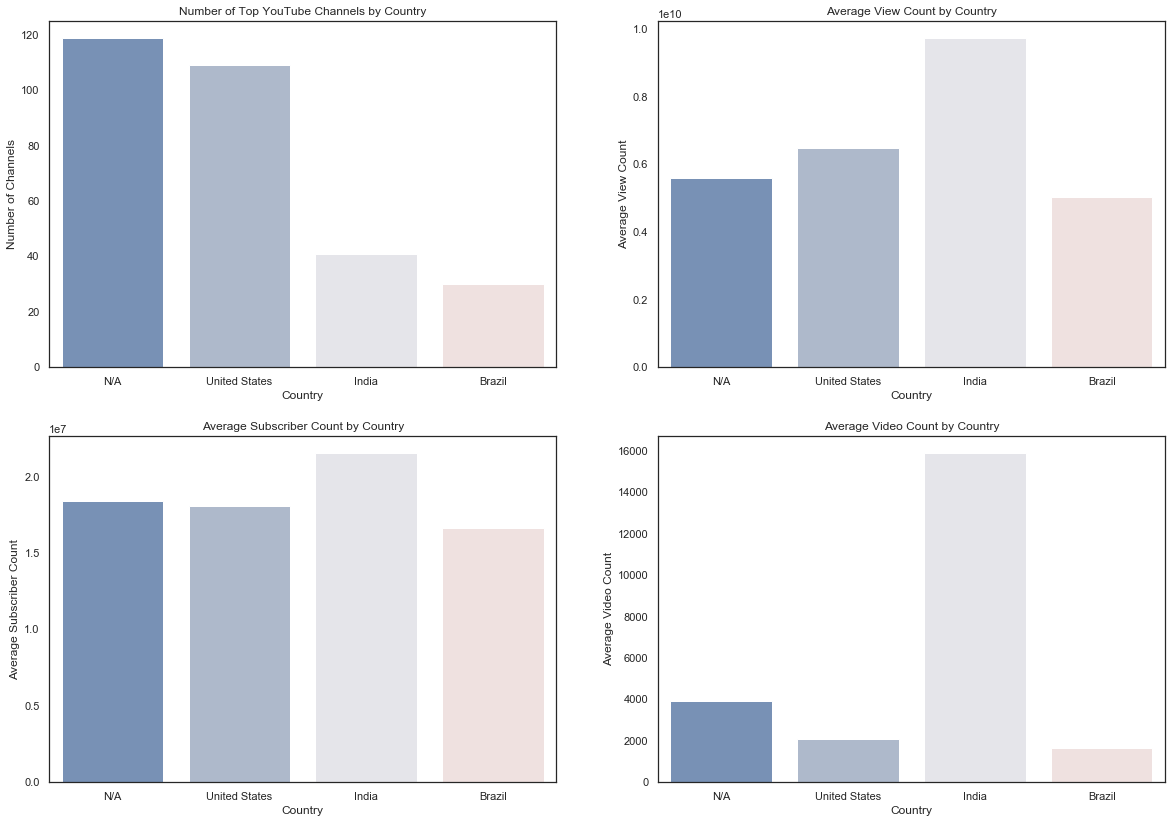

In [794]:
grid = (2,2) # Make a 2x2 axis grid to plot four plots in the same figure
fig = plt.figure(figsize=(20,14))
ax1 = plt.subplot2grid(grid, (0,0)) # First ax in position (0,0) (top left)
ax2 = plt.subplot2grid(grid, (0,1)) # Second ax in position (0,1) (top right)
ax3 = plt.subplot2grid(grid, (1,0)) # Third ax in position (1,0) (bottom left)
ax4 = plt.subplot2grid(grid, (1,1)) # Fourth ax in position (1,1) (bottom right)

sns.barplot(x=vis_df['country_name'],
            y=vis_df['COUNT(country)'],
            ax=ax1);

ax1.set_title('Number of Top YouTube Channels by Country');
ax1.set_xlabel('Country'), ax1.set_ylabel('Number of Channels');

sns.barplot(x=vis_df['country_name'],
            y=vis_df['AVG(view_count)'],
            ax=ax2)

ax2.set_title('Average View Count by Country');
ax2.set_xlabel('Country'), ax2.set_ylabel('Average View Count');

sns.barplot(x=vis_df['country_name'],
            y=vis_df['AVG(subscriber_count)'],
            ax=ax3);

ax3.set_title('Average Subscriber Count by Country');
ax3.set_xlabel('Country'), ax3.set_ylabel('Average Subscriber Count');



sns.barplot(x=vis_df['country_name'],
            y=vis_df['AVG(video_count)'],
            ax=ax4);

ax4.set_title('Average Video Count by Country');
ax4.set_xlabel('Country'), ax4.set_ylabel('Average Video Count');

## Genre Data

In [ ]:
#Visualization of Subscriber Count, View Count, and Video Count by Genre
test = genre_avg_table.head(3)

grid = (3,3) # Make a 2x2 axis grid to plot four plots in the same figure
fig = plt.figure(figsize=(14,14))
ax1 = plt.subplot2grid(grid, (0,0)) # First ax in position (0,0) (top left)
ax2 = plt.subplot2grid(grid, (0,1)) # Second ax in position (0,1) (top right)
ax3 = plt.subplot2grid(grid, (0,2)) # Third ax in position (1,0) (bottom left)


sns.barplot(x=test['genre_name'],y =test['AVG(ch.subscriber_count)'], ax=ax1)
ax1.set_title('Subscriber Count by Genre Tag');
ax1.set_xlabel('Genre Tag'), ax1.set_ylabel('Total Subscriber Count');

sns.barplot(x=test['genre_name'],y =test['AVG(ch.view_count)'], ax=ax2)
ax2.set_title('View Count by Genre Tag');
ax2.set_xlabel('Genre Tag'), ax2.set_ylabel('Total View Count');

sns.barplot(x=test['genre_name'],y =test['AVG(ch.video_count)'], ax=ax3)
ax3.set_title('Video Count by Genre Tag');
ax3.set_xlabel('Genre Tag'), ax3.set_ylabel('Total Video Count');

# plt.setp(axes, yticks=[])
plt.tight_layout()